#IMPORTS

In [ ]:
!pip install ucimlrepo
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from collections import Counter
from sklearn import tree
import matplotlib.pyplot as plt

#CONSTANTE

In [ ]:
FOLDS = 10

#FUNÇÕES GERAIS

In [ ]:
def normalizar_dados(X):
  x2 = X.values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x2)
  X = pd.DataFrame(x_scaled)
  return X

def kfolds(folds, X, y):
  kf = StratifiedKFold(n_splits = folds)

  X_train = []
  y_train = []

  X_test = []
  y_test = []

  X = np.array(X)
  y = np.array(y)

  for train_index, test_index in kf.split(X,y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])

    y_train.append(y[train_index])
    y_test.append(y[test_index])

  return X_train, y_train, X_test, y_test

def treinar_modelo(model,X_train,y_train,X_test,y_test):
  model = model.fit(X_train, y_train)
  result = model.predict(X_test)
  acc = metrics.accuracy_score(result, y_test)
  return acc, model

def arvore(folds, X_train, y_train, X_test, y_test, criterion):
  results = []
  for i in range(folds):
    model = DecisionTreeClassifier(criterion=criterion)
    acc,model = treinar_modelo(model,X_train[i],y_train[i],X_test[i],y_test[i])
    results.append(acc)
  return results

def knn(folds, X_train, y_train, X_test, y_test, k, metric, algorithm):
  results = []
  for i in range(folds):
    model = KNeighborsClassifier(n_neighbors=k, metric=metric, algorithm=algorithm)
    acc,model = treinar_modelo(model,X_train[i],y_train[i],X_test[i],y_test[i])
    results.append(acc)
  return results

def mlp(folds, X_train, y_train, X_test, y_test, hidden_layer_sizes, activation,max_inter):
  results = []
  for i in range(folds):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,max_iter=max_inter)
    acc,model = treinar_modelo(model,X_train[i],y_train[i],X_test[i],y_test[i])
    results.append(acc)
  titulo =  f"MLP {hidden_layer_sizes} {activation}"
  plotar_grafico_mlp(model.loss_curve_,titulo)
  return results

def plotar_grafico_mlp(list_loss_curve, title):
  plt.figure(figsize=[8,6])
  plt.plot(list_loss_curve , linewidth=3.0, color='purple', label='Curva de Perda')
  plt.legend(fontsize=18)
  plt.xlabel('Época ', fontsize=16)
  plt.ylabel('Perda', fontsize=16)
  plt.title(title, fontsize=16)
  plt.show()
  return

def kmeans(folds, X_train, y_train, X_test, y_test, clusters):
  results = []
  for j in range(folds):
    model = KMeans(n_clusters = clusters, n_init=10)
    model = model.fit(X_train[j])

    labels = model.labels_

    map_labels = []

    for i in range(clusters):
      map_labels.append([])

    new_y_train = y_train[j].tolist()

    for i in range(len(y_train[j])):
      for c in range(clusters):
        if labels[i] == c:
          map_labels[c].append(new_y_train[i])

    mapping = {}

    for i in range(clusters):
      final = Counter(map_labels[i])
      value = final.most_common(1)[0][0]
      mapping[i] = value

    result = model.predict(X_test[j])
    result = [mapping[i] for i in result]

    acc = metrics.accuracy_score(result, y_test[j])
    results.append(acc)
  return results

##1 - TELESCÓPIO MAGIC (Major Atmospheric Gamma Imaging Cherenkov)

In [ ]:
magic = fetch_ucirepo(id=159)

X = magic.data.features
y = magic.data.targets
y = np.reshape(y, (-1,))
X


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166


###PRÉ-PROCESSAMENTO

In [ ]:
X = normalizar_dados(X)
X

,0,1,2,3,4,5,6,7,8,9
0,0.074306,0.062415,0.208043,0.430390,0.293229,0.470032,0.620576,0.512493,0.445467,0.163066
1,0.082815,0.045727,0.170668,0.587794,0.558601,0.468649,0.623756,0.507944,0.070677,0.412679
2,0.478241,0.530579,0.626818,0.027617,0.027263,0.556215,0.468201,0.416540,0.855111,0.516926
3,0.059212,0.037338,0.117445,0.683714,0.580679,0.469558,0.570630,0.515219,0.116100,0.233582
4,0.214774,0.120603,0.360674,0.345153,0.271003,0.437870,0.632050,0.590373,0.051644,0.718582
...,...,...,...,...,...,...,...,...,...,...
19015,0.051838,0.042581,0.199527,0.650756,0.582457,0.457992,0.602182,0.541215,0.026921,0.213530
19016,0.074757,0.026141,0.096363,0.593249,0.412061,0.479112,0.605095,0.526076,0.964417,0.498046
19017,0.215712,0.185389,0.445594,0.146153,0.080901,0.434164,0.653983,0.509218,0.336652,0.516377
19018,0.352326,0.299950,0.606919,0.092397,0.100756,0.448838,0.417922,0.368263,0.940971,0.823491


In [ ]:
X_train, y_train, X_test, y_test = kfolds(FOLDS,X,y)

###DECISION TREES

In [ ]:
final_Results = {}
results_tree_gini = arvore(FOLDS,X_train,y_train,X_test,y_test,"gini")

show = round(np.mean(results_tree_gini) * 100)
final_Results["Tree Gini"] = [f"{show}%"]
print("{}%".format(show))

81%


In [ ]:
results_tree_entropy = arvore(FOLDS,X_train,y_train,X_test,y_test,"entropy")

show = round(np.mean(results_tree_entropy) * 100)
final_Results["Tree Entropy"] = [f"{show}%"]
print("{}%".format(show))

82%


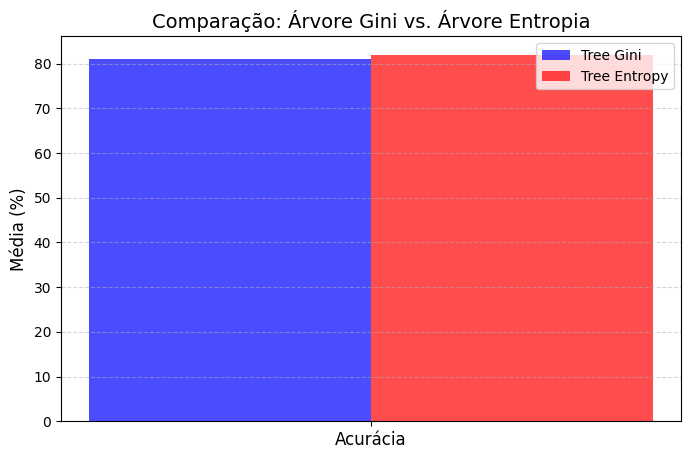

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

valores_gini = np.array([float(m.strip("%")) for m in final_Results["Tree Gini"]])
valores_entropy = np.array([float(m.strip("%")) for m in final_Results["Tree Entropy"]])

labels = ["Acurácia"]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_gini, width=0.4, label="Tree Gini", color="blue", alpha=0.7)
plt.bar(x + 0.2, valores_entropy, width=0.4, label="Tree Entropy", color="red", alpha=0.7)

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Média (%)", fontsize=12)
plt.title("Comparação: Árvore Gini vs. Árvore Entropia", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


###KNN

In [ ]:
results_KNN_5 = knn(FOLDS,X_train,y_train,X_test,y_test,5,'euclidean','brute')

show = round(np.mean(results_KNN_5) * 100)
final_Results["kNN 5"] = [f"{show}%"]
print("{}%".format(show))

84%


In [ ]:
results_KNN_10 = knn(FOLDS,X_train,y_train,X_test,y_test,10,'euclidean','brute')

show = round(np.mean(results_KNN_10) * 100)
final_Results["kNN 10"] = [f"{show}%"]
print("{}%".format(show))

84%


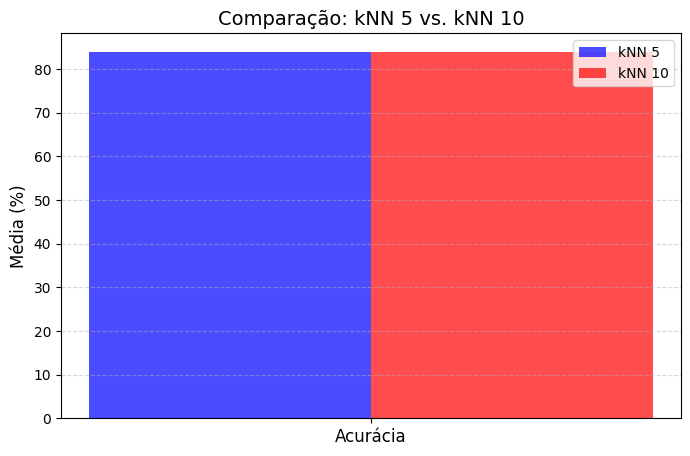

In [ ]:
valores_knn5 = np.array([float(m.strip("%")) for m in final_Results["kNN 5"]])
valores_knn10 = np.array([float(m.strip("%")) for m in final_Results["kNN 10"]])

labels = ["Acurácia"]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_knn5, width=0.4, label="kNN 5", color="blue", alpha=0.7)
plt.bar(x + 0.2, valores_knn10, width=0.4, label="kNN 10", color="red", alpha=0.7)

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Média (%)", fontsize=12)
plt.title("Comparação: kNN 5 vs. kNN 10", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


###MLP RELU

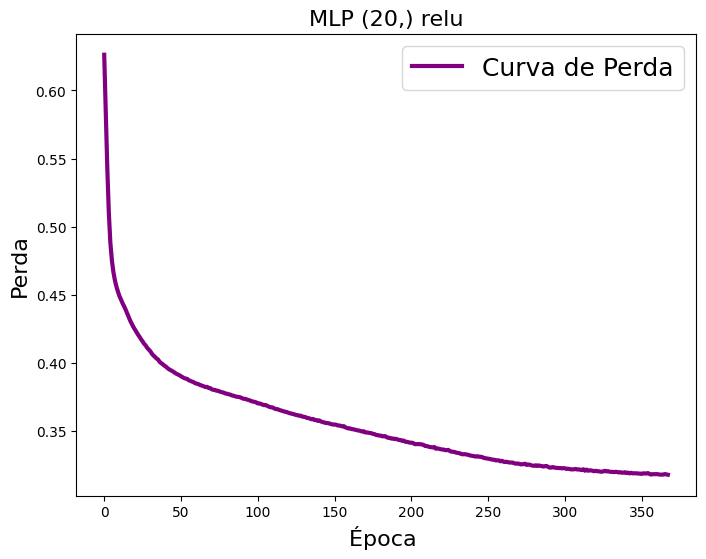

MLP 1 ReLU: 87%


In [ ]:
results_MLP_1_Relu = mlp(FOLDS, X_train, y_train, X_test, y_test, (20,), 'relu', 2000)
show = round(np.mean(results_MLP_1_Relu) * 100)
final_Results["MLP 1 Relu"] = [f"{show}%"]
print(f"MLP 1 ReLU: {show}%")

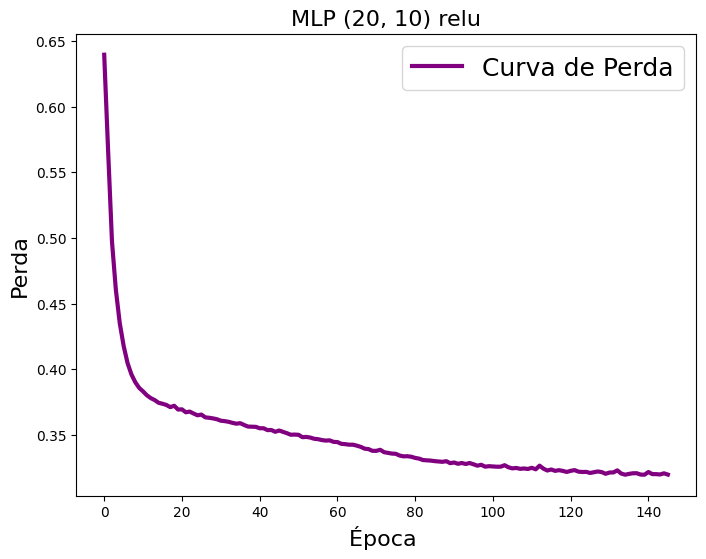

MLP 2 ReLU: 87%


In [ ]:
results_MLP_2_Relu = mlp(FOLDS, X_train, y_train, X_test, y_test, (20, 10), 'relu', 2000)
show = round(np.mean(results_MLP_2_Relu) * 100)
final_Results["MLP 2 Relu"] = [f"{show}%"]
print(f"MLP 2 ReLU: {show}%")

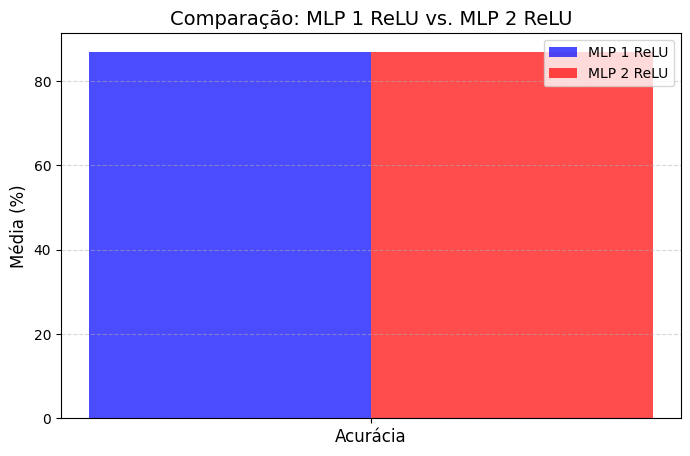

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

valores_mlp1_relu = np.array([float(m.strip("%")) for m in final_Results["MLP 1 Relu"]])
valores_mlp2_relu = np.array([float(m.strip("%")) for m in final_Results["MLP 2 Relu"]])

labels = ["Acurácia"]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_mlp1_relu, width=0.4, label="MLP 1 ReLU", color="blue", alpha=0.7)
plt.bar(x + 0.2, valores_mlp2_relu, width=0.4, label="MLP 2 ReLU", color="red", alpha=0.7)

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Média (%)", fontsize=12)
plt.title("Comparação: MLP 1 ReLU vs. MLP 2 ReLU", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


###MLP TANH

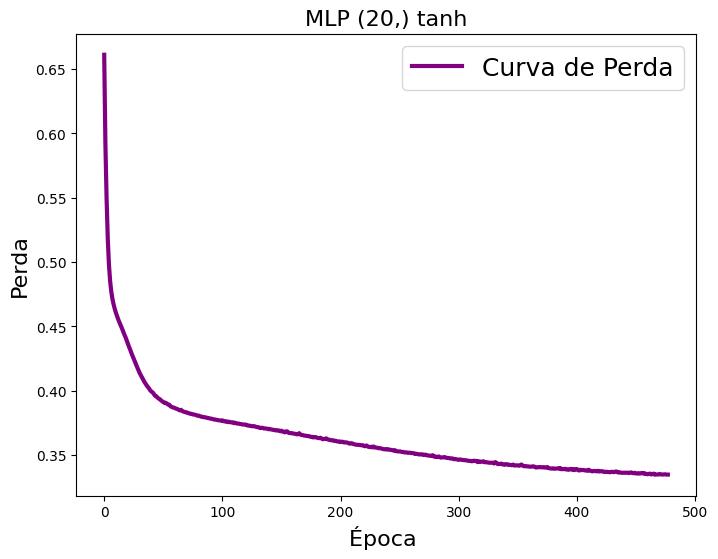

MLP 1 Tanh: 86%


In [ ]:
results_MLP_1_Tanh = mlp(FOLDS, X_train, y_train, X_test, y_test, (20,), 'tanh', 2000)
show = round(np.mean(results_MLP_1_Tanh) * 100)
final_Results["MLP 1 Tanh"] = [f"{show}%"]
print(f"MLP 1 Tanh: {show}%")

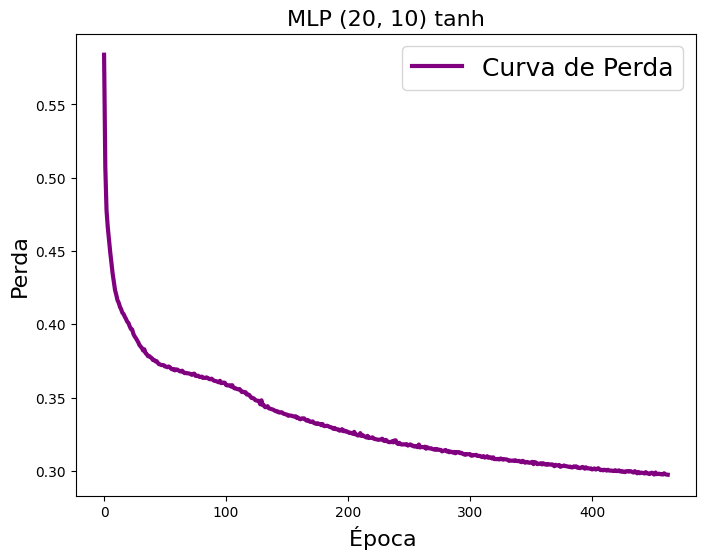

MLP 2 Tanh: 87%


In [ ]:
results_MLP_2_Tanh = mlp(FOLDS, X_train, y_train, X_test, y_test, (20, 10), 'tanh', 2000)
show = round(np.mean(results_MLP_2_Tanh) * 100)
final_Results["MLP 2 Tanh"] = [f"{show}%"]
print(f"MLP 2 Tanh: {show}%")

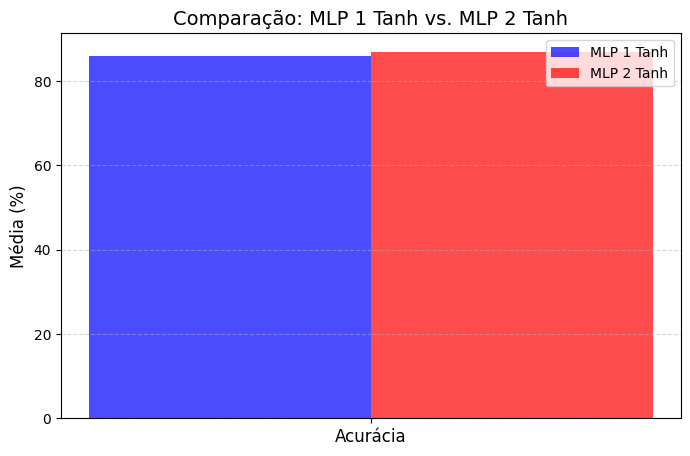

In [ ]:
valores_mlp1_tanh = np.array([float(m.strip("%")) for m in final_Results["MLP 1 Tanh"]])
valores_mlp2_tanh = np.array([float(m.strip("%")) for m in final_Results["MLP 2 Tanh"]])

labels = ["Acurácia"]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_mlp1_tanh, width=0.4, label="MLP 1 Tanh", color="blue", alpha=0.7)
plt.bar(x + 0.2, valores_mlp2_tanh, width=0.4, label="MLP 2 Tanh", color="red", alpha=0.7)

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Média (%)", fontsize=12)
plt.title("Comparação: MLP 1 Tanh vs. MLP 2 Tanh", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


##COMPARAÇÃO

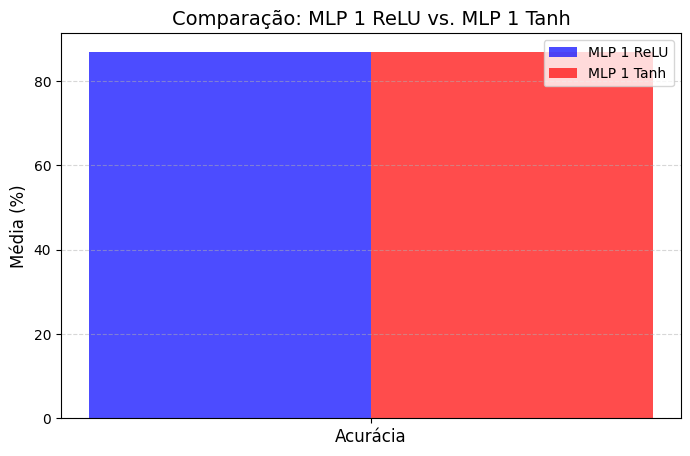

In [ ]:
valores_mlp1_relu = np.array([float(m.strip("%")) for m in final_Results["MLP 1 Relu"]])
valores_mlp1_tanh = np.array([float(m.strip("%")) for m in final_Results["MLP 1 Tanh"]])

labels = ["Acurácia"]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, valores_mlp1_relu, width=0.4, label="MLP 1 ReLU", color="blue", alpha=0.7)
plt.bar(x + 0.2, valores_mlp1_tanh, width=0.4, label="MLP 1 Tanh", color="red", alpha=0.7)

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Média (%)", fontsize=12)
plt.title("Comparação: MLP 1 ReLU vs. MLP 1 Tanh", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


###KMEANS


In [ ]:
clusters = len(set(y))
print(clusters)
results_KMEANS = kmeans(FOLDS,X_train,y_train,X_test,y_test,clusters)

show = round(np.mean(results_KMEANS) * 100)
final_Results["kMeans"] = [f"{show}%"]
print("{}%".format(show))

2
65%


###APRESENTAÇÃO

<ipython-input-21-817044631ce3>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = df.applymap(lambda x: float(x.strip('%')) if isinstance(x, str) else x)


<Figure size 1000x600 with 0 Axes>

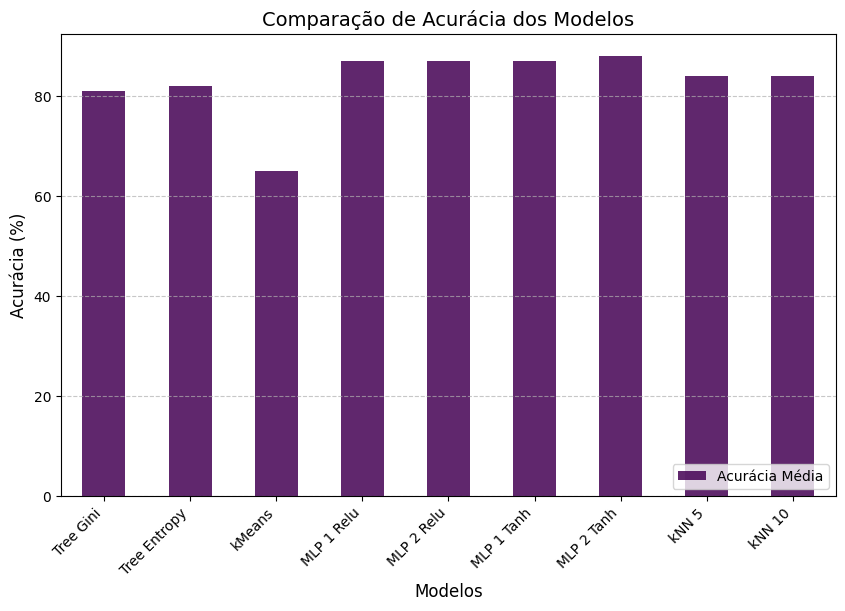

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame.from_dict(final_Results)

df_numeric = df.applymap(lambda x: float(x.strip('%')) if isinstance(x, str) else x)

plt.figure(figsize=(10, 6))
df_numeric.T.plot(kind="bar", figsize=(10, 6), colormap="viridis", alpha=0.85)

plt.title("Comparação de Acurácia dos Modelos", fontsize=14)
plt.ylabel("Acurácia (%)", fontsize=12)
plt.xlabel("Modelos", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(["Acurácia Média"], loc="lower right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


##2- SPAMBASE

In [ ]:
spambase = fetch_ucirepo(id=94)

# Inspecionar o conteúdo do dataset
X = spambase.data.features
y = spambase.data.targets
y = np.reshape(y, (-1,))
# X

In [ ]:
X = normalizar_dados(X)
# X

In [ ]:
X_train, y_train, X_test, y_test = kfolds(FOLDS, X, y)


In [ ]:
final_Results = {}
results_tree_gini = arvore(FOLDS,X_train,y_train,X_test,y_test,"gini")

#print(results_tree_gini)
show = round(np.mean(results_tree_gini) * 100)
final_Results["Tree Gini"] = [f"{show}%"]
print("{}%".format(show))

90%


In [ ]:
results_tree_entropy = arvore(FOLDS,X_train,y_train,X_test,y_test,"entropy")

#print(results_tree_entropy)
show = round(np.mean(results_tree_entropy) * 100)
final_Results["Tree Entropy"] = [f"{show}%"]
print("{}%".format(show))


91%


In [ ]:
results_KNN_5 = knn(FOLDS,X_train,y_train,X_test,y_test,5,'euclidean','auto')

#print(results_KNN_5)
show = round(np.mean(results_KNN_5) * 100)
final_Results["kNN 5"] = [f"{show}%"]
print("{}%".format(show))


88%


In [ ]:
results_KNN_10 = knn(FOLDS,X_train,y_train,X_test,y_test,10,'euclidean','auto')

#print(results_KNN_10)
show = round(np.mean(results_KNN_10) * 100)
final_Results["kNN 10"] = [f"{show}%"]
print("{}%".format(show))


88%


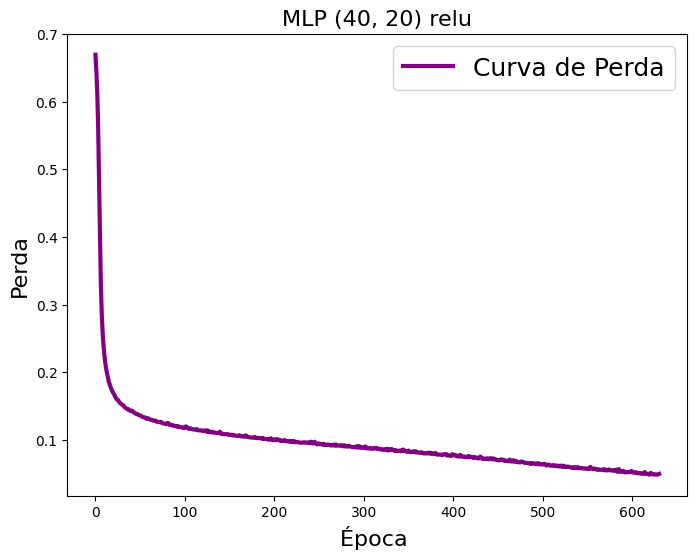

92%


In [ ]:
results_MLP_1_Relu = mlp(FOLDS,X_train,y_train,X_test,y_test,(40,20),'relu',2000)

show = round(np.mean(results_MLP_1_Relu) * 100)
final_Results["MLP 1 Relu"] = [f"{show}%"]
print("{}%".format(show))


In [ ]:
results_MLP_1_Tanh = mlp(FOLDS,X_train,y_train,X_test,y_test,(40,20),'tanh',2000)

#print(results_MLP_1_Tanh)
show = round(np.mean(results_MLP_1_Tanh) * 100)
final_Results["MLP 1 Tanh"] = [f"{show}%"]
print("{}%".format(show))


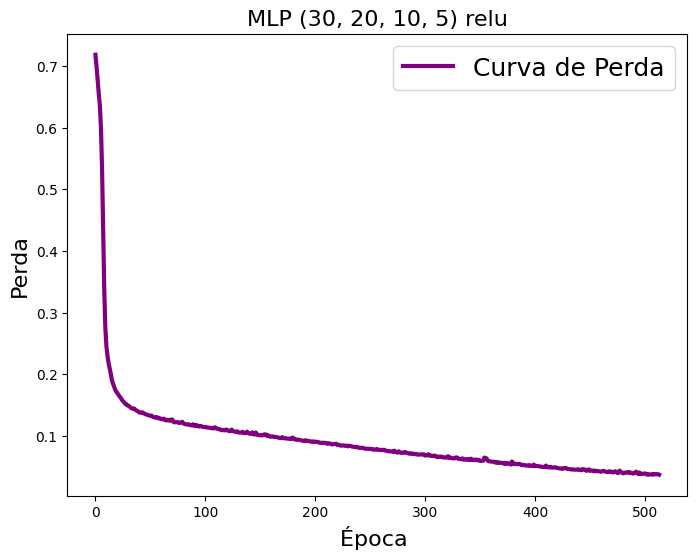

92%


In [ ]:
results_MLP_2_Relu = mlp(FOLDS,X_train,y_train,X_test,y_test,(30,20,10,5),'relu',2000)

#print(results_MLP_2_Relu)
show = round(np.mean(results_MLP_2_Relu) * 100)
final_Results["MLP 2 Relu"] = [f"{show}%"]
print("{}%".format(show))


In [ ]:
results_MLP_2_Tanh = mlp(FOLDS,X_train,y_train,X_test,y_test,(30,20,10,5),'tanh',2000)

#print(results_MLP_2_Tanh)
show = round(np.mean(results_MLP_2_Tanh) * 100)
final_Results["MLP 2 Tanh"] = [f"{show}%"]
print("{}%".format(show))


In [ ]:
clusters = len(set(y))
print(clusters)
results_KMEANS = kmeans(FOLDS,X_train,y_train,X_test,y_test,clusters)

#print(results_KMEANS)
show = round(np.mean(results_KMEANS) * 100)
final_Results["kMeans"] = [f"{show}%"]
print("{}%".format(show))

2
61%


In [ ]:
final_Results
df = pd.DataFrame.from_dict(final_Results)
df

,Tree Gini,Tree Entropy,MLP 1 Relu,kNN 10,MLP 2 Relu,kMeans
0,90%,91%,92%,88%,92%,61%
